# Assignment 1
Luke Schipper  
CS4210 - Machine Learning  
25 Feb 2021  






Note: This was created and tested in Google Colab. Please execute code in order.

This dataset contains the medical records of 299 patients who suffered heart failure in 2015. It is from a [research paper](https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5) published in 2020, in which the primary goal was to use machine learning to isolate key features that doctors should account for when measuring death risk. The paper did this using various classifier algorithms (many not covered yet in this course), and ultimately identified *serum creatinine* and *ejection fraction* as key features.

My further analysis of this dataset looks to determine the best model (of those covered in class) that incorporates the majority of the features in the dataset. Doing this, we can potentially overcome the main flaw of the original paper, which I believe to be the generalizability of their findings. The size of the dataset is quite small, so while the key features chosen might be suitable in classifying their test data, such features might fail to generalize outside that scope. Other features might also have measurable influence, so I will try to employ most of them in generating a more informed model.

My general approach:
* Split the dataset into a test and train set (40%, 60%). A large test set will hopefully promote generalizability. 
* Perform feature scaling using StandardScaler. Doing this, the features (all of which are using different units) will be scaled while still maintaining important information about outliers (which may help to distinguish people who are at more risk of death).
* Train and tune each proposed model with cross-validation, setting k to 3. A smaller k will allow for more training cycles, since the dataset is quite small. The models will be trained with balanced class_weights, since death outcomes are less common. As such, the models will be punished for being conservative in predicting a death outcome. For the same reason, the models will be scored using F1, which favours both precision and recall equally. In general, it is more beneficial to have true positives (death outcome) rather than true negatives (survive outcome) in such an important life-or-death application.
* The model with the highest cross-validation F1 score is chosen and the test data is applied. The model's performance is then summarized, with generalizability being discussed at the end.

# 1. Upload heart failure data in assignment folder, obtained from [UCI](https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records)

In [85]:
from google.colab import files

hf_file = files.upload()

Saving heart_failure_clinical_records_dataset.csv to heart_failure_clinical_records_dataset.csv


# 2. Store and display the dataset

In [86]:
import pandas as pd

hf_data = pd.read_csv('heart_failure_clinical_records_dataset.csv', index_col=0)
hf_data.head()

,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
age,,,,,,,,,,,,
75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


**Summary of features (Feature; Description; Measurement; Range):**  
  
**Age**; Of patient; Years; 40-95  
**Anaemia**; Decrease of red blood cells; Boolean; 0, 1  
**High blood pressure**; N/Y; Boolean; 0, 1  
**Creatinine phosphokinase**; Level in blood; mcg/L; 23-7861  
**Diabetes**; N/Y; Boolean; 0, 1  
**Ejection fraction**; Percent of blood leaving heart on each contraction; Percent; 14-80  
**Sex**; F/M; Boolean; 0, 1  
**Platelets**; Level in blood; kiloplatelets/mL; 25.01-850.00  
**Serum creatinine**; Level in blood; mg/dL; 0.50-9.40  
**Serum sodium**; Level in blood; mEq/L; 14-148  
**Smoking**; N/Y (does patient smoke); Boolean; 0, 1  
**Time**; Until next follow-up date; Days; 4-285  
**DEATH_EVENT (target)**; Survived/Died in follow-up period;  Boolean; 0, 1  


# 3. Visualize correlations/groupings between heart measurements in regard to death outcome

To begin, I graph some of the features against each other. Since there are quite a few features, I elected to graph only the ones that are measurements.

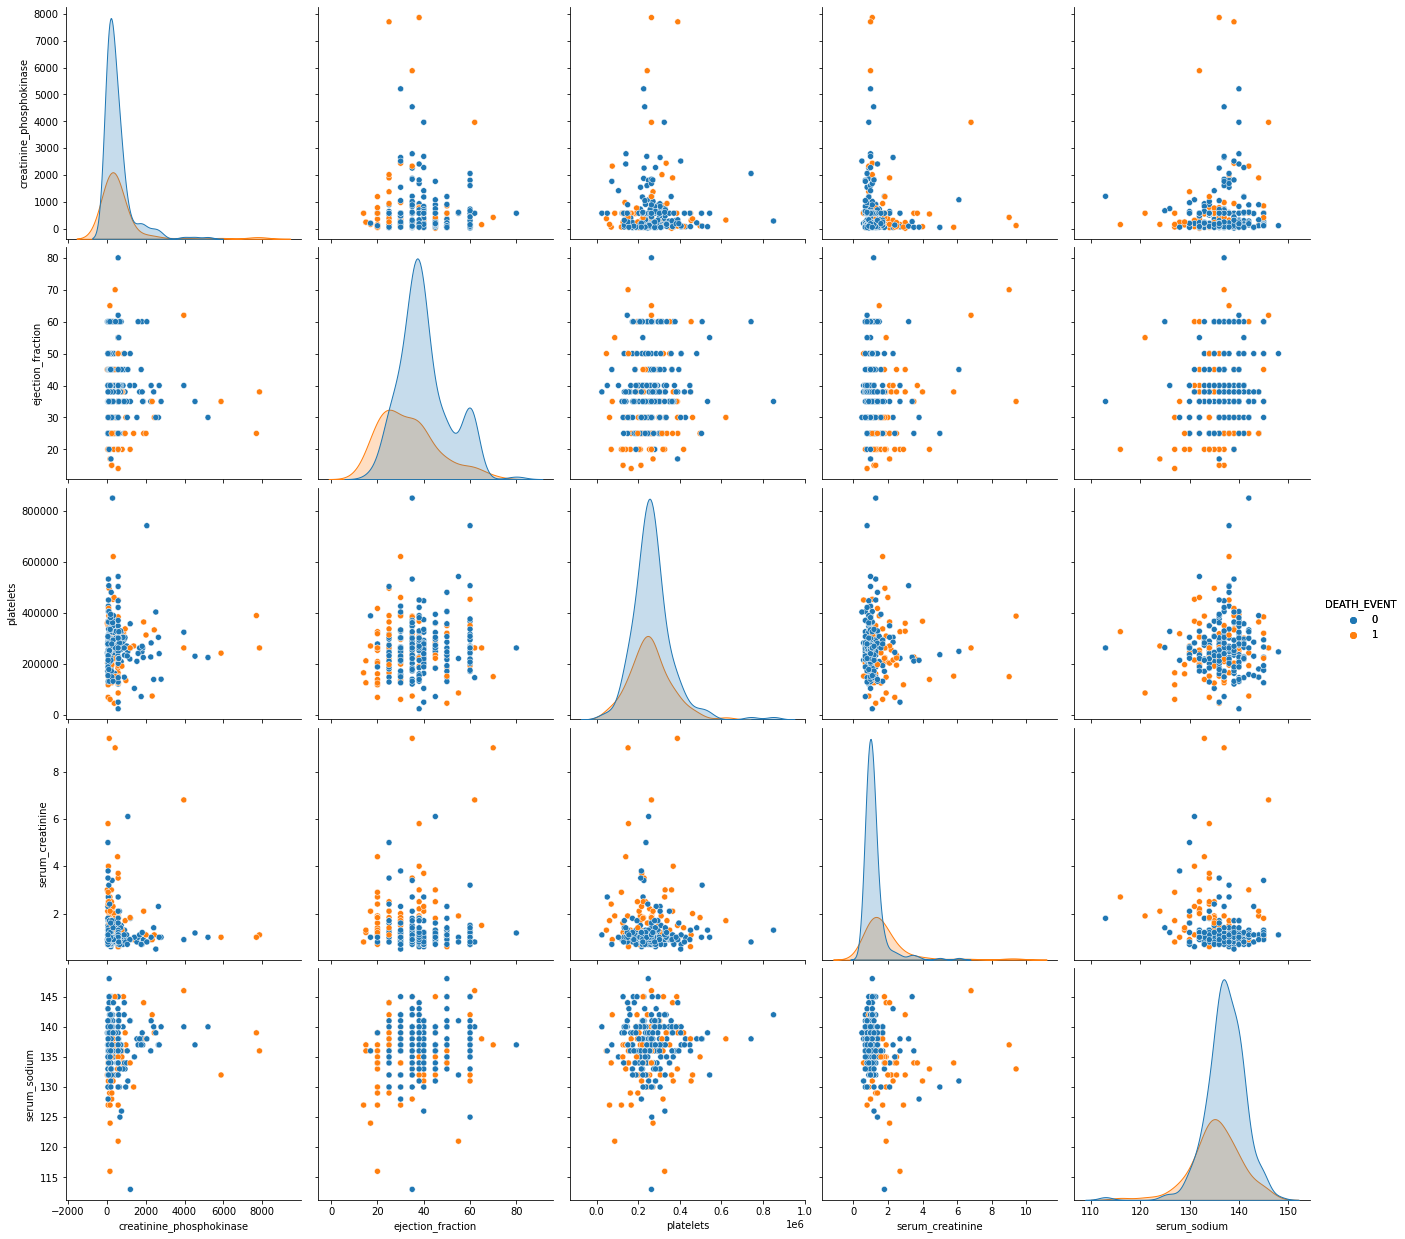

In [87]:
import seaborn as sns

# ~10 seconds to generate graphs 
meas_features = ['creatinine_phosphokinase', 'ejection_fraction', 'platelets', 'serum_creatinine', 'serum_sodium']
g = sns.pairplot(hf_data, hue='DEATH_EVENT', vars=meas_features, diag_kind='kde', height=3.5)
g.add_legend()
meas_features.append('time')

A few observations:
* There are some noticeable groupings. The cleanest are (serum_sodium, serum_creatinine), (serum_creatinine, platelets), and (platelets, creatinine_phosphokinase). I choose these because in each there is a high concentration of blue (survival events) in a contained area. However, it is evident that there is no generalizable grouping for which either event is entirely contained. It seems death events tend to indicate extreme outlier measurements, but even then, some outliers still survive.
* A few feature comparisons are very sporadic, such as (serum_sodium, platelets) and (creatinine_phosphokinase, serum_sodium).
* The mean ejection fraction of those who died seems to be lower than those who survived.

# 4. View heart measurement summary statistics for those who lived and died

In [88]:
# For those who survived.
hf_data[hf_data.DEATH_EVENT == 0][meas_features].describe()

,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
count,203.000000,203.000000,203.000000,203.000000,203.000000,203.000000
mean,540.054187,40.266010,266657.489901,1.184877,137.216749,158.339901
std,753.799572,10.859963,97531.202283,0.654083,3.982923,67.742872
min,30.000000,17.000000,25100.000000,0.500000,113.000000,12.000000
25%,109.000000,35.000000,219500.000000,0.900000,135.500000,95.000000
50%,245.000000,38.000000,263000.000000,1.000000,137.000000,172.000000
75%,582.000000,45.000000,302000.000000,1.200000,140.000000,213.000000
max,5209.000000,80.000000,850000.000000,6.100000,148.000000,285.000000


In [89]:
# For those who died.
hf_data[hf_data.DEATH_EVENT == 1][meas_features].describe()

,creatinine_phosphokinase,ejection_fraction,platelets,serum_creatinine,serum_sodium,time
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,670.197917,33.468750,256381.044792,1.835833,135.375000,70.885417
std,1316.580640,12.525303,98525.682856,1.468562,5.001579,62.378281
min,23.000000,14.000000,47000.000000,0.600000,116.000000,4.000000
25%,128.750000,25.000000,197500.000000,1.075000,133.000000,25.500000
50%,259.000000,30.000000,258500.000000,1.300000,135.500000,44.500000
75%,582.000000,38.000000,311000.000000,1.900000,138.250000,102.250000
max,7861.000000,70.000000,621000.000000,9.400000,146.000000,241.000000


My final observation from above is confirmed. Ejection fraction is lower in those who died. Further, creatinine phosphokinase is considerably higher. Follow-up time is much higher for those who survived, which might indicate that smaller follow-up time correlates to 
deteriorating health conditions.

# 5. Visualize the categorical features of those who lived and died

Next, I visualize the distributation of categorical features.

Text(0.5, 1.0, 'DEATH_EVENT = 0')

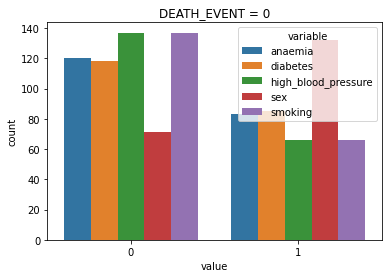

In [90]:
cat_features = ['anaemia', 'diabetes', 'high_blood_pressure', 'sex', 'smoking']
hf_data_catplot_0 = pd.DataFrame(hf_data[hf_data.DEATH_EVENT == 0], columns=cat_features)
hf_data_catplot_1 = pd.DataFrame(hf_data[hf_data.DEATH_EVENT == 1], columns=cat_features)
sns.countplot(x='value', hue='variable', data=pd.melt(hf_data_catplot_0)).set_title('DEATH_EVENT = 0')

Text(0.5, 1.0, 'DEATH_EVENT = 1')

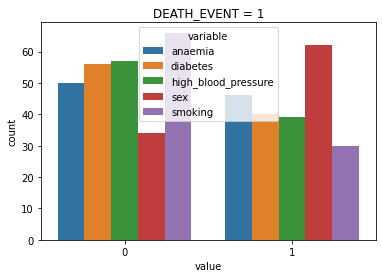

In [91]:
sns.countplot(x='value', hue='variable', data=pd.melt(hf_data_catplot_1)).set_title('DEATH_EVENT = 1')

There are only small differences between DEATH_EVENT = 0 (survived) and DEATH_EVENT = 1 (died).
* Deaths were slightly more likely to be anaemic.
* Deaths were slightly more likely to have high blood pressure.
* Regardless of death event, many of the patients (who all at some point suffered heart failure) were diabetic and/or smokers. A majority of patients were men. There is likely a correlation between all of these features and heart failure, but not necessarily death.


# 6. Logistic regression with linear features

Starting with logistic regression, I first split and scale the data. Then I try to determine the best solving algorithm. Note that each model has class_weight='balanced' to improve F1 scoring, making the model more likely to predict positive death outcomes.

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

features = meas_features + cat_features
x_train, x_test, y_train, y_test = train_test_split(hf_data[features], hf_data['DEATH_EVENT'], test_size=0.40, random_state=0)
scaler = StandardScaler()
x_train_scl = scaler.fit_transform(x_train)
x_test_scl = scaler.fit_transform(x_test)

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

lgr_solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
lgr_scores = []
for slvr in lgr_solvers:
  lgr = LogisticRegression(solver=slvr, class_weight='balanced')
  lgr_scores.append((slvr, cross_val_score(lgr, x_train_scl, y_train, cv=3, scoring='f1').mean()))
print('Scores:\t{}'.format(lgr_scores))
print('Max:\t{}'.format(max(lgr_scores, key=lambda x: x[1])))

Scores:	[('newton-cg', 0.643380036928424), ('lbfgs', 0.643380036928424), ('liblinear', 0.6518518518518519), ('sag', 0.643380036928424), ('saga', 0.643380036928424)]
Max:	('liblinear', 0.6518518518518519)


We see that liblinear performs the best, but the difference is not significant. I try again, but perform dimension reduction with LDA. With only two categories, the 11-dimension data is projected on to a single axis. I chose LDA since it is better at maximizing separability between classes, unlike PCA (and, having tried PCA, LDA seems to give better F1 scores). 

I read up on both [here](https://www.digitalvidya.com/blog/linear-discriminant-analysis/).

In [93]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline

lgr_scores = []
for slvr in lgr_solvers:
    steps = [('lda', LinearDiscriminantAnalysis(n_components=1)), ('lgr', LogisticRegression(solver=slvr, class_weight='balanced'))]
    model = Pipeline(steps=steps)
    lgr_scores.append((slvr, cross_val_score(model, x_train_scl, y_train, cv=3, scoring='f1').mean()))
print('Scores:\t{}'.format(lgr_scores))
print('Max:\t{}'.format(max(lgr_scores, key=lambda x: x[1])))

Scores:	[('newton-cg', 0.6388711802456544), ('lbfgs', 0.6388711802456544), ('liblinear', 0.6487385869678252), ('sag', 0.6388711802456544), ('saga', 0.6388711802456544)]
Max:	('liblinear', 0.6487385869678252)


We see that liblinear still does the best, but LDA did not help. Below I test the found model against the test set and summarize the results.

              precision    recall  f1-score   support

           0       0.91      0.78      0.84        82
           1       0.64      0.84      0.73        38

    accuracy                           0.80       120
   macro avg       0.78      0.81      0.78       120
weighted avg       0.83      0.80      0.81       120



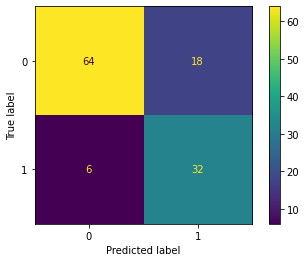

In [94]:
from sklearn.metrics import classification_report,plot_confusion_matrix

lgr = LogisticRegression(solver='liblinear', class_weight='balanced')
lgr.fit(x_train_scl, y_train)
print(classification_report(y_test, lgr.predict(x_test_scl)))
plot_confusion_matrix(lgr, x_test_scl, y_test)

This model, for all its simplicity, performs admirably well. We see that F1 score actually increased between cross-validation and testing. Further, it is fairly precise with negative classifications in comparison to the other models that will be presented. Since the model performed better on test data, it seems to generalize well (though I wish I had more data available). To finish, I generate some decision boundaries to see how the model did.

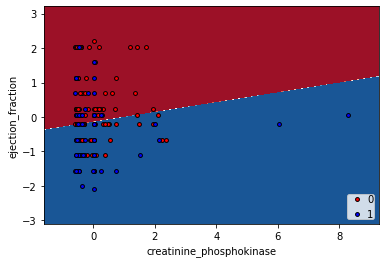

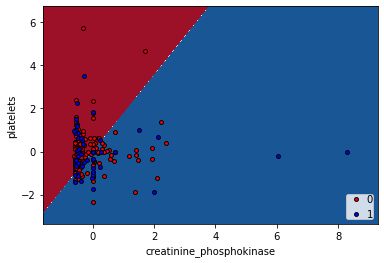

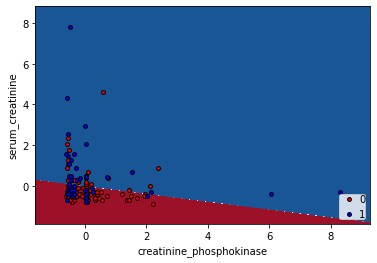

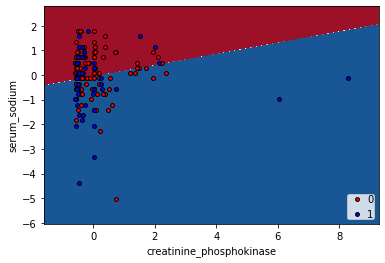

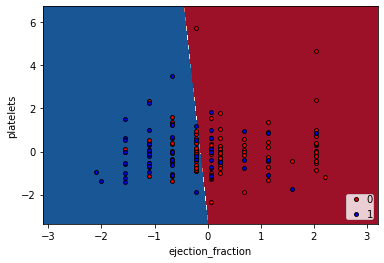

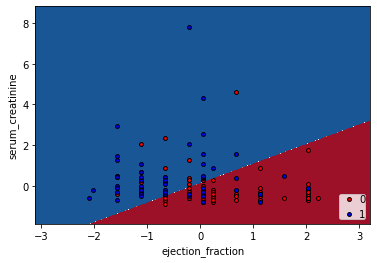

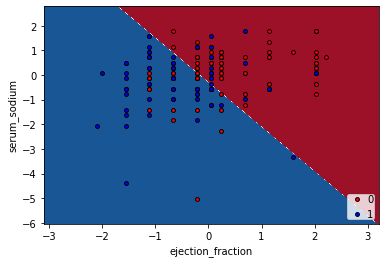

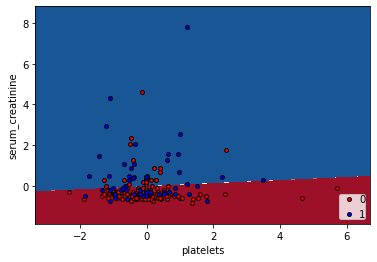

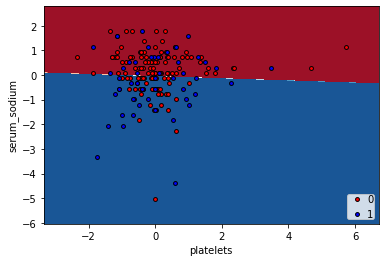

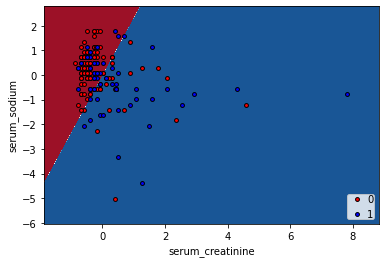

In [95]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations

# modified from https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html

def plot_decision_boundary(model, pair):
    x_sub = x_train_scl[:, list(pair)]
    model.fit(x_sub, y_train)
    x_min, x_max = x_sub[:, 0].min() - 1, x_sub[:, 0].max() + 1
    y_min, y_max = x_sub[:, 1].min() - 1, x_sub[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu)
    plt.xlabel(features[pair[0]])
    plt.ylabel(features[pair[1]])
    for i, color in zip(range(2), 'rb'):
        idx = np.where(y_train == i)
        plt.scatter(x_sub[idx, 0], x_sub[idx, 1], c=color, label=i, edgecolor='black', s=15)
    plt.legend(loc='lower right', borderpad=0, handletextpad=0)
    plt.show()
  
def generate_meas_plots(model):
  meas_combs = list(combinations(range(0, len(meas_features) - 1), 2))
  for comb in meas_combs:
    plot_decision_boundary(model, comb)

generate_meas_plots(lgr)

Of course, we are not seeing the full picture with these boundaries, since the model is only being trained on two features at a time when generating these graphs. However, we can see that the general essence of the data is being categorized, though admittedly not very well.

# 7. Logistic regression with polynomial features

Next, I attempt to perform logistic regression again with polynomial features. I begin by tuning the degree without any LDA applied. Since the choice of solver seems to make little difference, I choose to use liblinear exclusively.

In [96]:
from sklearn.preprocessing import PolynomialFeatures

lgr_scores = []
for i in range(2, 5):
  steps = [('plf', PolynomialFeatures(degree=i)), ('lgr', LogisticRegression(solver='liblinear', class_weight='balanced'))]
  model = Pipeline(steps=steps)
  lgr_scores.append((i, cross_val_score(model, x_train_scl, y_train, cv=3, scoring='f1').mean()))
print('Scores:\t{}'.format(lgr_scores))
print('Max:\t{}'.format(max(lgr_scores, key=lambda x: x[1])))

Scores:	[(2, 0.4787654320987655), (3, 0.5404761904761904), (4, 0.5057957279288474)]
Max:	(3, 0.5404761904761904)


So far the results are looking poor. Due to the 11 features, raising the degree makes training take too long. Applying LDA will allow me to reduce the features and raise the degree higher.

[Text(0, 0.5, 'F1'), Text(0.5, 0, 'Degree')]

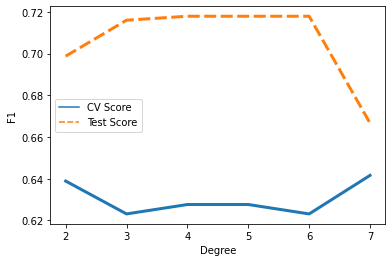

In [97]:
from sklearn.metrics import f1_score

v_plots = []
for i in range(2, 8):
  steps = [('lda', LinearDiscriminantAnalysis(n_components=1)), ('plf', PolynomialFeatures(degree=i)), ('lgr', LogisticRegression(solver='liblinear', class_weight='balanced'))]
  model = Pipeline(steps=steps)
  cv_score = cross_val_score(model, x_train_scl, y_train, cv=3, scoring='f1').mean()
  model.fit(x_train_scl, y_train)
  test_score = f1_score(y_test, model.predict(x_test_scl))
  v_plots.append([cv_score, test_score])
v_plots_df = pd.DataFrame(v_plots, range(2, 8), columns=['CV Score', 'Test Score'])
sns.lineplot(data=v_plots_df, linewidth=3).set(xlabel='Degree', ylabel='F1')

Now the model is doing better. CV score has gone up significantly. The above graph, however, shows that at degree 6, CV score increases significantly while test score decreases significantly. I believe this to be the point of overfitting, so I elect to choose the second highest CV score model, which is degree 2. Now to summarize the results:

              precision    recall  f1-score   support

           0       0.88      0.80      0.84        82
           1       0.64      0.76      0.70        38

    accuracy                           0.79       120
   macro avg       0.76      0.78      0.77       120
weighted avg       0.81      0.79      0.80       120



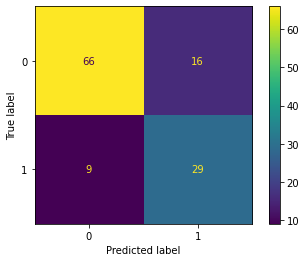

In [98]:
steps = [('lda', LinearDiscriminantAnalysis(n_components=1)), ('plf', PolynomialFeatures(degree=2)), ('lgr', LogisticRegression(solver='liblinear', class_weight='balanced'))]
model = Pipeline(steps=steps)
model.fit(x_train_scl, y_train)
print(classification_report(y_test, model.predict(x_test_scl)))
plot_confusion_matrix(model, x_test_scl, y_test)

In comparison to the linear logistic regression model, this one is slightly better at predicting negatives and slightly worse at predicting positives. The motivation for this assignment is to find the model with the best F1 score, however, so this one is inferior. Lastly, some boundary lines:

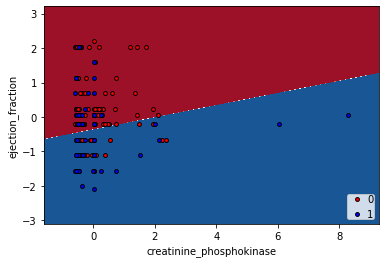

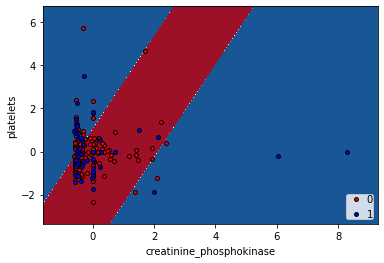

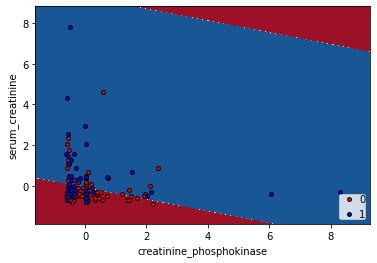

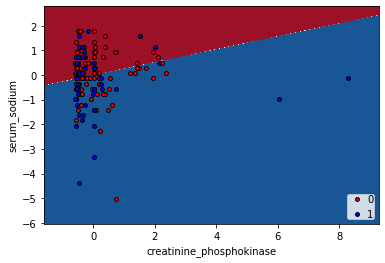

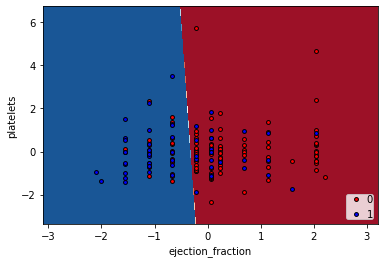

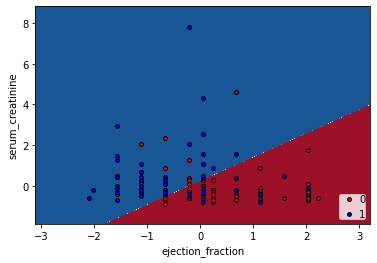

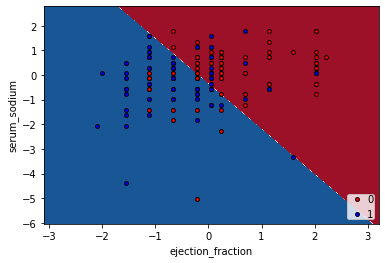

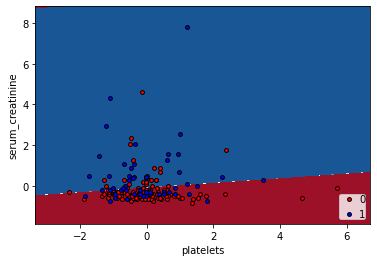

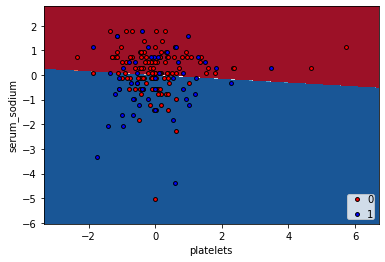

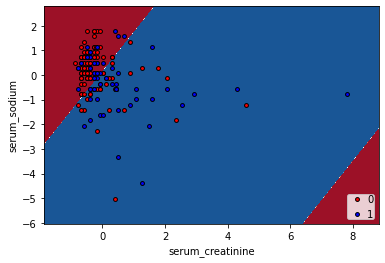

In [99]:
generate_meas_plots(model)

This model seems to be slightly better at fitting the data, with the extra degree allowing for multiline separation. However, it still seems to do a poor job (in regard to two feature training, at least).

# 8. Decision tree

Lastly, I attempt to train a decision tree. There are a couple of parameters that can be tuned, which I read about [here](https://towardsdatascience.com/how-to-tune-a-decision-tree-f03721801680/). I choose to tune min_samples_leaf (for which optimal values tend to fall between 1 and 20) and min_samples_split (for which optimal values tend to fall between 2 and 40). Both these parameters seem to have the most influence on the performance of the classifier, with min_samples_leaf forcing a minimum number of samples at each leaf node, and min_samples_split requiring a certain number of samples to continue splitting the tree. Thus, both parameters help prevent overfitting.

In [100]:
from sklearn.tree import DecisionTreeClassifier
 
# ~10 seconds required to run this block
dtc_scores = []
for i in range(1, 21):
  for j in range(2, 41):
    dtc = DecisionTreeClassifier(random_state=0, class_weight='balanced', min_samples_leaf=i, min_samples_split=j)
    dtc_scores.append((i, j, cross_val_score(dtc, x_train_scl, y_train, cv=3, scoring='f1').mean()))
print('Max:\t{}'.format(max(dtc_scores, key=lambda x: x[2])))

Max:	(7, 26, 0.7121309715512614)


We get a very high CV score with min_samples_leaf set to 7 and min_samples_split set to 26. I take a quick look at the boundaries to see if overfitting is occurring.

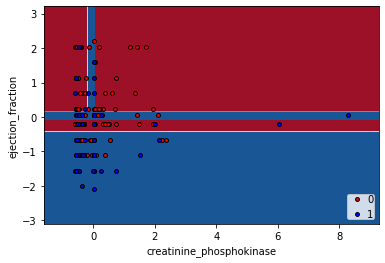

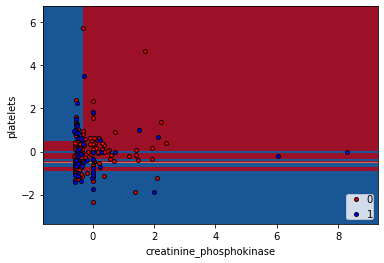

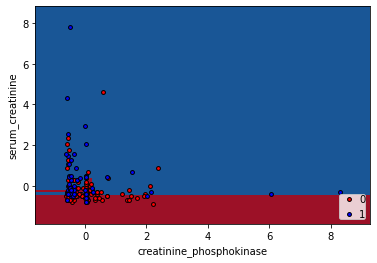

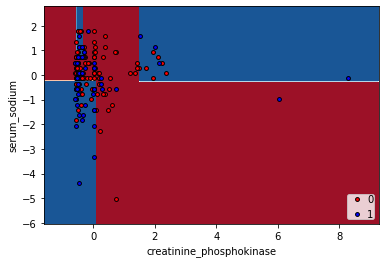

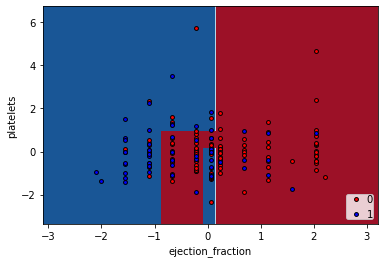

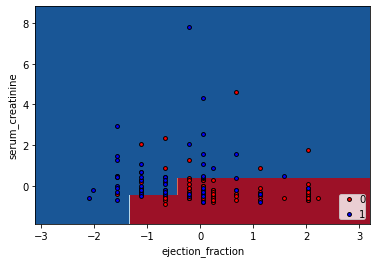

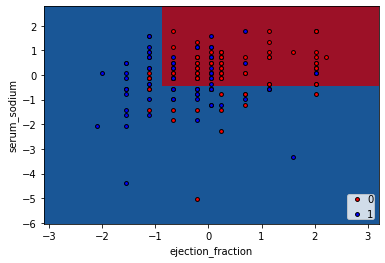

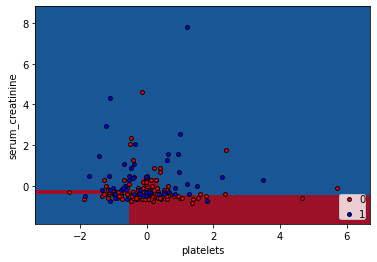

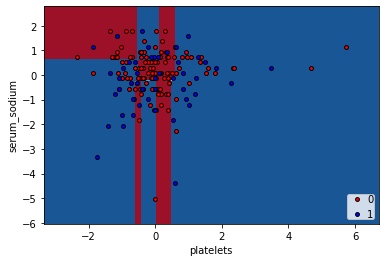

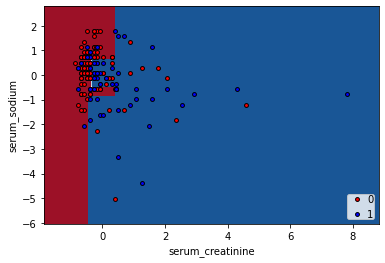

In [101]:
dtc = DecisionTreeClassifier(random_state=0, class_weight='balanced', min_samples_leaf=7, min_samples_split=26)
generate_meas_plots(dtc)

The decision tree draws the most complex boundaries yet. They seem to do a decent job categorizing the data points. There are, however, many points that still fall outside of their correct boundaries, so it appears overfitting has yet to occur.

              precision    recall  f1-score   support

           0       0.89      0.77      0.82        82
           1       0.61      0.79      0.69        38

    accuracy                           0.78       120
   macro avg       0.75      0.78      0.76       120
weighted avg       0.80      0.78      0.78       120

Depth of tree	5


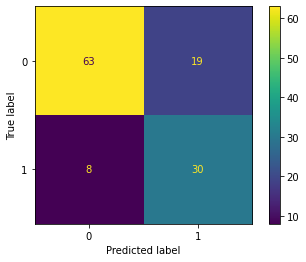

In [102]:
dtc = DecisionTreeClassifier(random_state=0, class_weight='balanced', min_samples_leaf=7, min_samples_split=26)
dtc.fit(x_train_scl, y_train)
print(classification_report(y_test, dtc.predict(x_test_scl)))
plot_confusion_matrix(dtc, x_test_scl, y_test)
print('Depth of tree\t{}'.format(dtc.tree_.max_depth))

This model remains inferior to linear logistic regression. It is slightly better than polynomial regression at predicting death outcomes, but still falls short of linear. Furthermore, it is worse than both at predicting survival outcomes. Thus, it falls short in both accuracy and F1 score and is thus rejected. The depth of this decision tree is 5, so to see if I could do better than this, I tried tuning the max depth of the tree to promote generalizability.

In [103]:
# ~20 seconds required to run this block
dtc_scores = []
for i in range(1, 21):
  for j in range(2, 41):
    for k in range(1, 6):
      dtc = DecisionTreeClassifier(random_state=0, class_weight='balanced', min_samples_leaf=i, min_samples_split=j, max_depth=k)
      dtc_scores.append((i, j, k, cross_val_score(dtc, x_train_scl, y_train, cv=3, scoring='f1').mean()))
print('Max:\t{}'.format(max(dtc_scores, key=lambda x: x[3])))
# Max:	(7, 25, 3, 0.7266552998010797)

Max:	(7, 25, 3, 0.7266552998010797)


I test the model setting max_depth to 3. However, there is no improvement.

              precision    recall  f1-score   support

           0       0.89      0.77      0.82        82
           1       0.61      0.79      0.69        38

    accuracy                           0.78       120
   macro avg       0.75      0.78      0.76       120
weighted avg       0.80      0.78      0.78       120



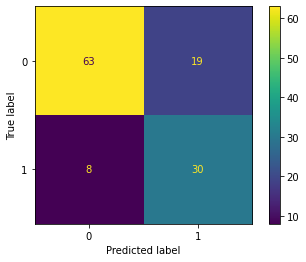

In [104]:
dtc = DecisionTreeClassifier(random_state=0, class_weight='balanced', min_samples_leaf=7, min_samples_split=25, max_depth=3)
dtc.fit(x_train_scl, y_train)
print(classification_report(y_test, dtc.predict(x_test_scl)))
plot_confusion_matrix(dtc, x_test_scl, y_test)

# 9. Conclusion

In conclusion, the best-performing model from those I trained is logistic regression with linear features. This also happens to be the most simplistic model, with the least parameter tuning. Only the solver (which makes little impact) and class_weights were tuned. As noted previously, setting class_weights to 'balanced' greatly improved F1 performance, and made the model much better at outputting true positives. After all, if a patient is at risk of death, false negatives are of much more consequence than false positives.

In general, feature scaling improved the performance across all models slightly. LDA dimension reduction helped in the case of polynomial logistic regression, where reducing the dimensionality of the dataset allowed me to train with higher degrees.

Without more data, it is unclear if my model will generalize well. A lack of data remains a major barrier for both my analysis and that of the original research paper. With more data, we might see polynomial logistic regression perform better. Tuning the degree would hopefully allow me to find a value that maximizes CV score without overfitting the CV data, which is quite small currently (approx. 180 rows). The same could also be said for min_samples_split and min_samples_leaf.

However, since the logistic regression model was trained with all meaningful features, one might be more reassured that, if there is other key features besides those mentioned in the original study, the model will be better at classifying patients that do not currently fit the mold of the dataset. 




In [105]:
lgr = LogisticRegression(solver='liblinear', class_weight='balanced')
lgr.fit(x_train_scl, y_train)
for idx, co in enumerate(lgr.coef_[0]):
  if abs(co) < 0.1:
    print((features[idx], co))

('platelets', -0.09814627676406835)
('anaemia', 0.04231125522509345)
('diabetes', -0.065768283845448)


From the coefficients, we can see that every feature contributes at least somewhat to the output of the model. Some contributions are currently quite small (platelets, anaemia, diabetes) but this could change with more training data.